# Telecom Churn Prediction 

**Authors:** Mahalakshmi Totad

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

Goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

### Reference Notes : Models to build
1. Build a predictive model using PCA, this will be able to achieve one of the two goals - to predict customers who will churn.
2. Use any classification model, with the main objective of identifying important predictor attributes which help the business understand indicators of churn. - A good choice to identify important variables is a logistic regression model or a model from the tree family. 

### Understanding how to handle class imbalance in classification models might be the key to winning this competition.
    
The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation

## Exploratory Data Analysis & Preprocessing

### 1. Data understanding and exploration
Let's first import the required libraries and have a look at the dataset and understand the size, attribute names etc.

In [274]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [275]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Auto EDA
import sweetviz as sv

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [292]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


"data" will be the dataset used for training and model evalutaion

In [293]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [294]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

Let's also summarize the features using the df.describe method:

In [295]:
data.describe(include="all")

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999,69600,69266,69999.000000,69999.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
unique,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,69999,69600,69266,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34999.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,283.134365,278.185912,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,NaN,NaN,NaN,334.213918,344.366927,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,-2258.709000,-1289.715000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,93.581000,86.714000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,197.484000,191.588000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,370.791000,365.369500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000


In [296]:
# sweet_report ta,pairwise_analysis="off")
# sweet_report.show_html('swee= sv.analyze(dat_report.html')

## 2. Data Cleaning


### Remove unuseful columns


In [297]:
data['circle_id'].unique()

array([109])

In [298]:
columns_with_non_unique_values = ['circle_id']

In [299]:
# columns_with_non_unique_values = ['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','og_others_7','og_others_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8',']

In [300]:
data.shape

(69999, 172)

In [301]:
data.drop(columns_with_non_unique_values, axis = 1, inplace = True)

In [302]:
data.shape

(69999, 171)

In [303]:
# y= data.pop('churn_probability')
# X = data
# X.shape, y.shape

In [304]:
# create column name list by types of columns
date_cols = ['last_date_of_month_6',
             'last_date_of_month_7',
             'last_date_of_month_8',
             'date_of_last_rech_6',
             'date_of_last_rech_7',
             'date_of_last_rech_8',
             'date_of_last_rech_data_6',
             'date_of_last_rech_data_7',
             'date_of_last_rech_data_8',
            ]

cat_cols =  ['night_pck_user_6',
             'night_pck_user_7',
             'night_pck_user_8',
             'fb_user_6',
             'fb_user_7',
             'fb_user_8',
            ]

num_cols = [column for column in data.columns if column not in date_cols + cat_cols]

# print the number of columns in each list
print("#Date cols:%d\n#Numeric cols:%d\n#Category cols:%d" % (len(date_cols), len(num_cols), len(cat_cols)))

# check if we have missed any column or not
print( len(date_cols) + len(num_cols) + len(cat_cols) == data.shape[1])

#Date cols:9
#Numeric cols:156
#Category cols:6
True


### Handling Missing data

Lets analyse the missing data.

#### Imputation

In [305]:
data.shape

(69999, 171)

In [306]:
# some recharge columns have minimum value of 1 while some don't
recharge_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
                 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 
                 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
                 ]

data[recharge_cols].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
count,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000
mean,2.467612,2.679989,2.652441,1.865323,2.056311,2.016018,0.602288,0.623678,0.636423,126.500000,126.402071,125.374925,192.831096,201.455940,196.815792
std,2.794610,3.073472,3.101265,2.566377,2.799916,2.728246,1.279297,1.401230,1.457058,109.352573,109.459266,109.648799,190.623115,198.346141,192.280532
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,25.000000,25.000000,25.000000,82.000000,92.000000,84.000000
50%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,145.000000,145.000000,145.000000,154.000000,154.000000,154.000000
75%,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,177.000000,177.000000,179.000000,252.000000,252.000000,252.000000
max,61.000000,54.000000,60.000000,42.000000,48.000000,44.000000,29.000000,34.000000,45.000000,1555.000000,1555.000000,1555.000000,5920.000000,4365.000000,4076.000000


In [307]:
# It is also observed that the recharge date and the recharge value are missing together which means the customer didn't recharge
data.loc[data.total_rech_data_6.isnull() & data.date_of_last_rech_data_6.isnull(), ["total_rech_data_6", "date_of_last_rech_data_6"]].head(20)

,total_rech_data_6,date_of_last_rech_data_6
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN
6,NaN,NaN
8,NaN,NaN
9,NaN,NaN
11,NaN,NaN
12,NaN,NaN


In the recharge variables where minumum value is 1, we can impute missing values with zeroes since it means customer didn't recharge their numbere that month.

In [308]:
# create a list of recharge columns where we will impute missing values with zeroes
zero_impute = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
        'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
        'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8'
       ]

In [309]:
# impute missing values with 0
data[zero_impute] = data[zero_impute].apply(lambda x: x.fillna(0))

In [310]:
# now, let's make sure values are imputed correctly
print("Missing value ratio:\n")
print(data[zero_impute].isnull().sum()*100/data.shape[1])

# summary
print("\n\nSummary statistics\n")
print(data[zero_impute].describe(include='all'))

Missing value ratio:

total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
dtype: float64


Summary statistics

       total_rech_data_6  total_rech_data_7  total_rech_data_8  \
count       69999.000000       69999.000000       69999.000000   
mean            0.619309           0.683981           0.697867   
std             1.762010           1.943193           1.973434   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             1.000000           1.000000           1.000000   
max            61.000000          54.000000          60.000000   

       av_rech_amt_data_6  av_rech_amt_data_7  av_rech_amt_data_8  \
count        69999.000000        69999.0000

All min values for 'zero_impute' columns is zero. Hence we can say that imputation was successful.

In [311]:
# drop id and date columns
print("Shape before dropping: ", data.shape)
data = data.drop(date_cols, axis=1)
print("Shape after dropping: ", data.shape)

Shape before dropping:  (69999, 171)
Shape after dropping:  (69999, 162)


### Replace NaN values in categorical variables

We will replace missing values in the categorical values with '-1' where '-1' will be a new category.

In [312]:
# replace missing values with '-1' in categorical columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.fillna(-1))

In [313]:
# missing value ratio
print("Missing value ratio:\n")
print(data[cat_cols].isnull().sum()*100/data.shape[0])

Missing value ratio:

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [314]:
data.shape

(69999, 162)

In [315]:
# Handle missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = 100*(data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
arpu_3g_6,52431,74.902499
arpu_2g_6,52431,74.902499
count_rech_2g_6,52431,74.902499
count_rech_3g_6,52431,74.902499
arpu_2g_7,52134,74.478207


In [316]:
missing_data_percent = 100*data.isnull().sum()/len(data)
missing_data_percent

id                   0.000000
loc_og_t2o_mou       1.002871
std_og_t2o_mou       1.002871
loc_ic_t2o_mou       1.002871
arpu_6               0.000000
                       ...   
aon                  0.000000
aug_vbc_3g           0.000000
jul_vbc_3g           0.000000
jun_vbc_3g           0.000000
churn_probability    0.000000
Length: 162, dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 30% missing data.

In [317]:
new_vars = missing_data_percent[missing_data_percent.le(30)].index
new_vars

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=150)

In [318]:
data_filtered = data[new_vars]
data_filtered.shape

(69999, 150)

In [319]:
missing_data_percent = data_filtered.isnull().any()
missing_data_percent

id                   False
loc_og_t2o_mou        True
std_og_t2o_mou        True
loc_ic_t2o_mou        True
arpu_6               False
                     ...  
aon                  False
aug_vbc_3g           False
jul_vbc_3g           False
jun_vbc_3g           False
churn_probability    False
Length: 150, dtype: bool

#### Imputation using Simple Imputer

In [320]:
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
       'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_o

In [321]:
imp = SimpleImputer(strategy='constant', fill_value=0)
data_filtered[impute_cols] = imp.fit_transform(data_filtered[impute_cols])

In [322]:
data_filtered.shape

(69999, 150)

In [323]:
data_filtered.describe()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69999.0,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,0.0,0.0,0.0,283.134365,278.185912,278.858826,127.887939,128.754731,125.943607,...,0.081444,0.085487,-0.519050,-0.512650,-0.502650,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,334.213918,344.366927,351.924315,295.115497,306.326345,304.990552,...,0.634547,0.680035,0.842376,0.845053,0.847641,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,0.0,0.0,0.0,93.581000,86.714000,84.095000,5.430000,4.910000,4.110000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,0.0,0.0,0.0,197.484000,191.588000,192.234000,30.830000,29.160000,27.840000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,0.0,0.0,0.0,370.791000,365.369500,369.909000,113.100000,108.940000,106.280000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


#### Inference : We can see there are outliers so let's clean it up

### Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [324]:
### Now we will determine the data type of all features remaining

In [325]:
types_X_train = data_filtered.dtypes #type of each feature in data: int, float, object
num_X_train = types_X_train[(types_X_train == 'int64') | (types_X_train == float)] #numerical values are either type int or float
cat_X_train = types_X_train[types_X_train == object] #categorical values are type object

In [326]:
#we should convert num_train to a list to make it easier to work with
numericColumns = list(num_X_train.index)
len(numericColumns)

150

In [327]:
print(numericColumns)

['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8

In [328]:
cat_X_train = types_X_train[types_X_train == object] #categorical values are type object

In [329]:
categoricalColumns = list(cat_X_train.index)
print(categoricalColumns)
print(len(categoricalColumns))

[]
0


In [330]:
numericColumns.remove('id')
print(numericColumns)

['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'to

In [331]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [332]:
data_filtered = data_filtered[numericColumns].apply(cap_outliers, axis=0)

In [333]:
data_filtered.shape

(69999, 149)

<Axes: >

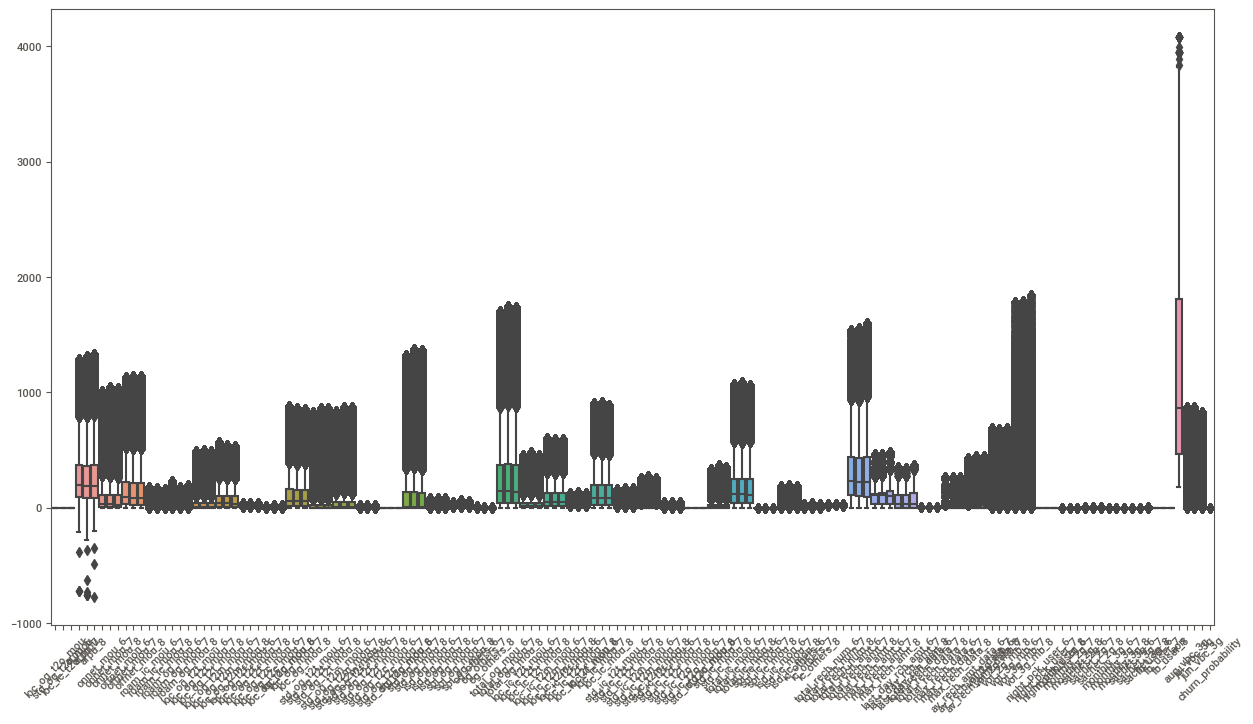

In [334]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data =data_filtered[numericColumns])

In [335]:
data_filtered.shape

(69999, 149)

### 3. Data Preparation
Alanyse variables and derive new and useful variables

#### Filter high-value customers

### calculate total data recharge amount

In [336]:
churn = data_filtered

In [337]:
# calculate the total data recharge amount for June and July --> number of recharges * average recharge amount
churn['total_data_rech_6'] = churn.total_rech_data_6 * churn.av_rech_amt_data_6
churn['total_data_rech_7'] = churn.total_rech_data_7 * churn.av_rech_amt_data_7

### add total data recharge and total recharge to get total combined recharge amount for a month

In [338]:
# calculate total recharge amount for June and July --> call recharge amount + data recharge amount
churn['amt_data_6'] = churn.total_rech_amt_6 + churn.total_data_rech_6
churn['amt_data_7'] = churn.total_rech_amt_7 + churn.total_data_rech_7

In [339]:
# calculate average recharge done by customer in June and July
churn['av_amt_data_6_7'] = (churn.amt_data_6 + churn.amt_data_7)/2

In [340]:
# look at the 70th percentile recharge amount
print("Recharge amount at 70th percentile: {0}".format(churn.av_amt_data_6_7.quantile(0.7)))

Recharge amount at 70th percentile: 477.0


In [341]:
# retain only those customers who have recharged their mobiles with more than or equal to 70th percentile amount
churn_filtered = churn.loc[churn.av_amt_data_6_7 >= churn.av_amt_data_6_7.quantile(0.7), :]
churn_filtered = churn_filtered.reset_index(drop=True)
churn_filtered.shape

(21011, 154)

In [342]:
# delete variables created to filter high-value customers
churn_filtered = churn_filtered.drop(['total_data_rech_6', 'total_data_rech_7',
                                      'amt_data_6', 'amt_data_7', 'av_amt_data_6_7'], axis=1)
churn_filtered.shape

(21011, 149)

We're left with 21,011 rows after selecting the customers who have provided recharge value of more than or equal to the recharge value of the 70th percentile customer.

### derive churn

In [343]:
# calculate total incoming and outgoing minutes of usage
# churn_filtered['total_calls_mou_8'] = churn_filtered.total_ic_mou_8 + churn_filtered.total_og_mou_8

In [344]:
# calculate 2g and 3g data consumption
# churn_filtered['total_internet_mb_8'] =  churn_filtered.vol_2g_mb_8 + churn_filtered.vol_3g_mb_8

In [345]:
# create churn variable: those who have not used either calls or internet in the month of August are customers who have churned

# 0 - not churn, 1 - churn
# churn_filtered['churn'] = churn_filtered.apply(lambda row: 1 if (row.total_calls_mou_8 == 0 and row.total_internet_mb_8 == 0) else 0, axis=1)

In [346]:
# delete derived variables
# churn_filtered = churn_filtered.drop(['total_calls_mou_8', 'total_internet_mb_8'], axis=1)

In [347]:
# change data type to category
# churn_filtered.churn = churn_filtered.churn.astype("category")

# print churn ratio
# print("Churn Ratio:")
print(churn_filtered.churn_probability.value_counts()*100/churn_filtered.shape[0])

0    91.74718
1     8.25282
Name: churn_probability, dtype: float64


In [348]:
churn_filtered.shape

(21011, 149)

In [349]:
columns = churn_filtered.columns
columns

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'offnet_mou_6',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=149)

### Calculate difference between 8th and previous months

Let's derive some variables. The most important feature, in this situation, can be the difference between the 8th month and the previous months. The difference can be in patterns such as usage difference or recharge value difference. Let's calculate difference variable as the difference between 8th month and the average of 6th and 7th month.

In [350]:
# churn_filtered['arpu_diff'] = churn_filtered.arpu_8 - ((churn_filtered.arpu_6 + churn_filtered.arpu_7)/2)

# churn_filtered['onnet_mou_diff'] = churn_filtered.onnet_mou_8 - ((churn_filtered.onnet_mou_6 + churn_filtered.onnet_mou_7)/2)

# churn_filtered['offnet_mou_diff'] = churn_filtered.offnet_mou_8 - ((churn_filtered.offnet_mou_6 + churn_filtered.offnet_mou_7)/2)

# churn_filtered['roam_ic_mou_diff'] = churn_filtered.roam_ic_mou_8 - ((churn_filtered.roam_ic_mou_6 + churn_filtered.roam_ic_mou_7)/2)

# churn_filtered['roam_og_mou_diff'] = churn_filtered.roam_og_mou_8 - ((churn_filtered.roam_og_mou_6 + churn_filtered.roam_og_mou_7)/2)

# churn_filtered['loc_og_mou_diff'] = churn_filtered.loc_og_mou_8 - ((churn_filtered.loc_og_mou_6 + churn_filtered.loc_og_mou_7)/2)

# churn_filtered['std_og_mou_diff'] = churn_filtered.std_og_mou_8 - ((churn_filtered.std_og_mou_6 + churn_filtered.std_og_mou_7)/2)

# churn_filtered['isd_og_mou_diff'] = churn_filtered.isd_og_mou_8 - ((churn_filtered.isd_og_mou_6 + churn_filtered.isd_og_mou_7)/2)

# churn_filtered['spl_og_mou_diff'] = churn_filtered.spl_og_mou_8 - ((churn_filtered.spl_og_mou_6 + churn_filtered.spl_og_mou_7)/2)

# churn_filtered['total_og_mou_diff'] = churn_filtered.total_og_mou_8 - ((churn_filtered.total_og_mou_6 + churn_filtered.total_og_mou_7)/2)

# churn_filtered['loc_ic_mou_diff'] = churn_filtered.loc_ic_mou_8 - ((churn_filtered.loc_ic_mou_6 + churn_filtered.loc_ic_mou_7)/2)

# churn_filtered['std_ic_mou_diff'] = churn_filtered.std_ic_mou_8 - ((churn_filtered.std_ic_mou_6 + churn_filtered.std_ic_mou_7)/2)

# churn_filtered['isd_ic_mou_diff'] = churn_filtered.isd_ic_mou_8 - ((churn_filtered.isd_ic_mou_6 + churn_filtered.isd_ic_mou_7)/2)

# churn_filtered['spl_ic_mou_diff'] = churn_filtered.spl_ic_mou_8 - ((churn_filtered.spl_ic_mou_6 + churn_filtered.spl_ic_mou_7)/2)

# churn_filtered['total_ic_mou_diff'] = churn_filtered.total_ic_mou_8 - ((churn_filtered.total_ic_mou_6 + churn_filtered.total_ic_mou_7)/2)

# churn_filtered['total_rech_num_diff'] = churn_filtered.total_rech_num_8 - ((churn_filtered.total_rech_num_6 + churn_filtered.total_rech_num_7)/2)

# churn_filtered['total_rech_amt_diff'] = churn_filtered.total_rech_amt_8 - ((churn_filtered.total_rech_amt_6 + churn_filtered.total_rech_amt_7)/2)

# churn_filtered['max_rech_amt_diff'] = churn_filtered.max_rech_amt_8 - ((churn_filtered.max_rech_amt_6 + churn_filtered.max_rech_amt_7)/2)

# churn_filtered['total_rech_data_diff'] = churn_filtered.total_rech_data_8 - ((churn_filtered.total_rech_data_6 + churn_filtered.total_rech_data_7)/2)

# churn_filtered['max_rech_data_diff'] = churn_filtered.max_rech_data_8 - ((churn_filtered.max_rech_data_6 + churn_filtered.max_rech_data_7)/2)

# churn_filtered['av_rech_amt_data_diff'] = churn_filtered.av_rech_amt_data_8 - ((churn_filtered.av_rech_amt_data_6 + churn_filtered.av_rech_amt_data_7)/2)

# churn_filtered['vol_2g_mb_diff'] = churn_filtered.vol_2g_mb_8 - ((churn_filtered.vol_2g_mb_6 + churn_filtered.vol_2g_mb_7)/2)

# churn_filtered['vol_3g_mb_diff'] = churn_filtered.vol_3g_mb_8 - ((churn_filtered.vol_3g_mb_6 + churn_filtered.vol_3g_mb_7)/2)

In [351]:
# let's look at summary of one of the difference variables
# churn_filtered['total_og_mou_diff'].describe()

In [352]:
churn_filtered.shape

(21011, 149)

### UniVaraite Analysis

#### Visulaization

<Axes: >

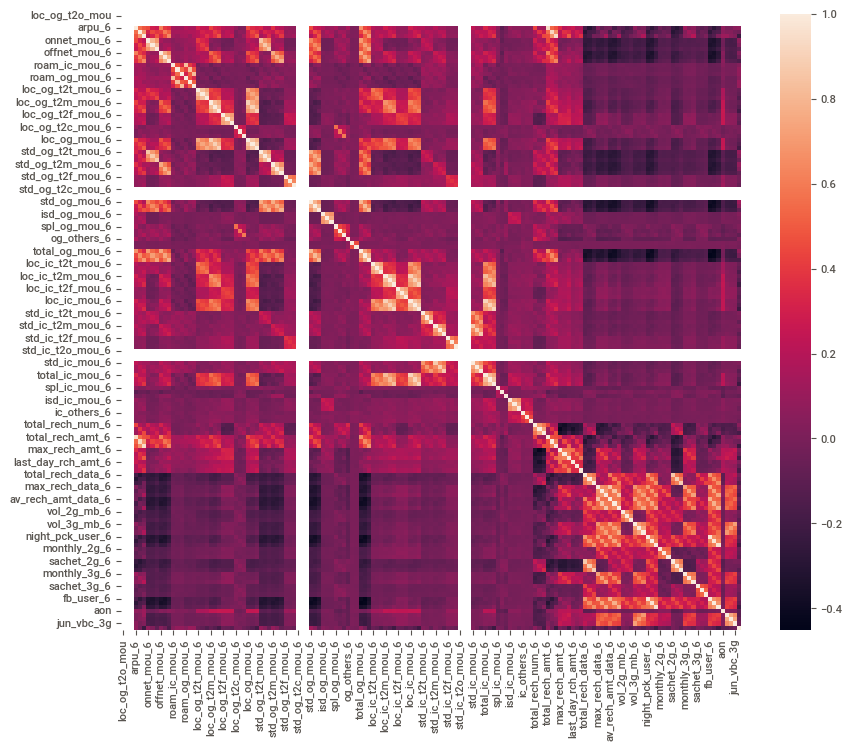

In [353]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(churn_filtered, columns=churn_filtered.columns).corr())

In [354]:
print(len(numericColumns))
print(len(categoricalColumns))

149
0


In [355]:
sl = slice(0, 75)
print(len(numericColumns[sl]))

75


In [356]:
# There are no categorical variables left, let's visualize numeric variables

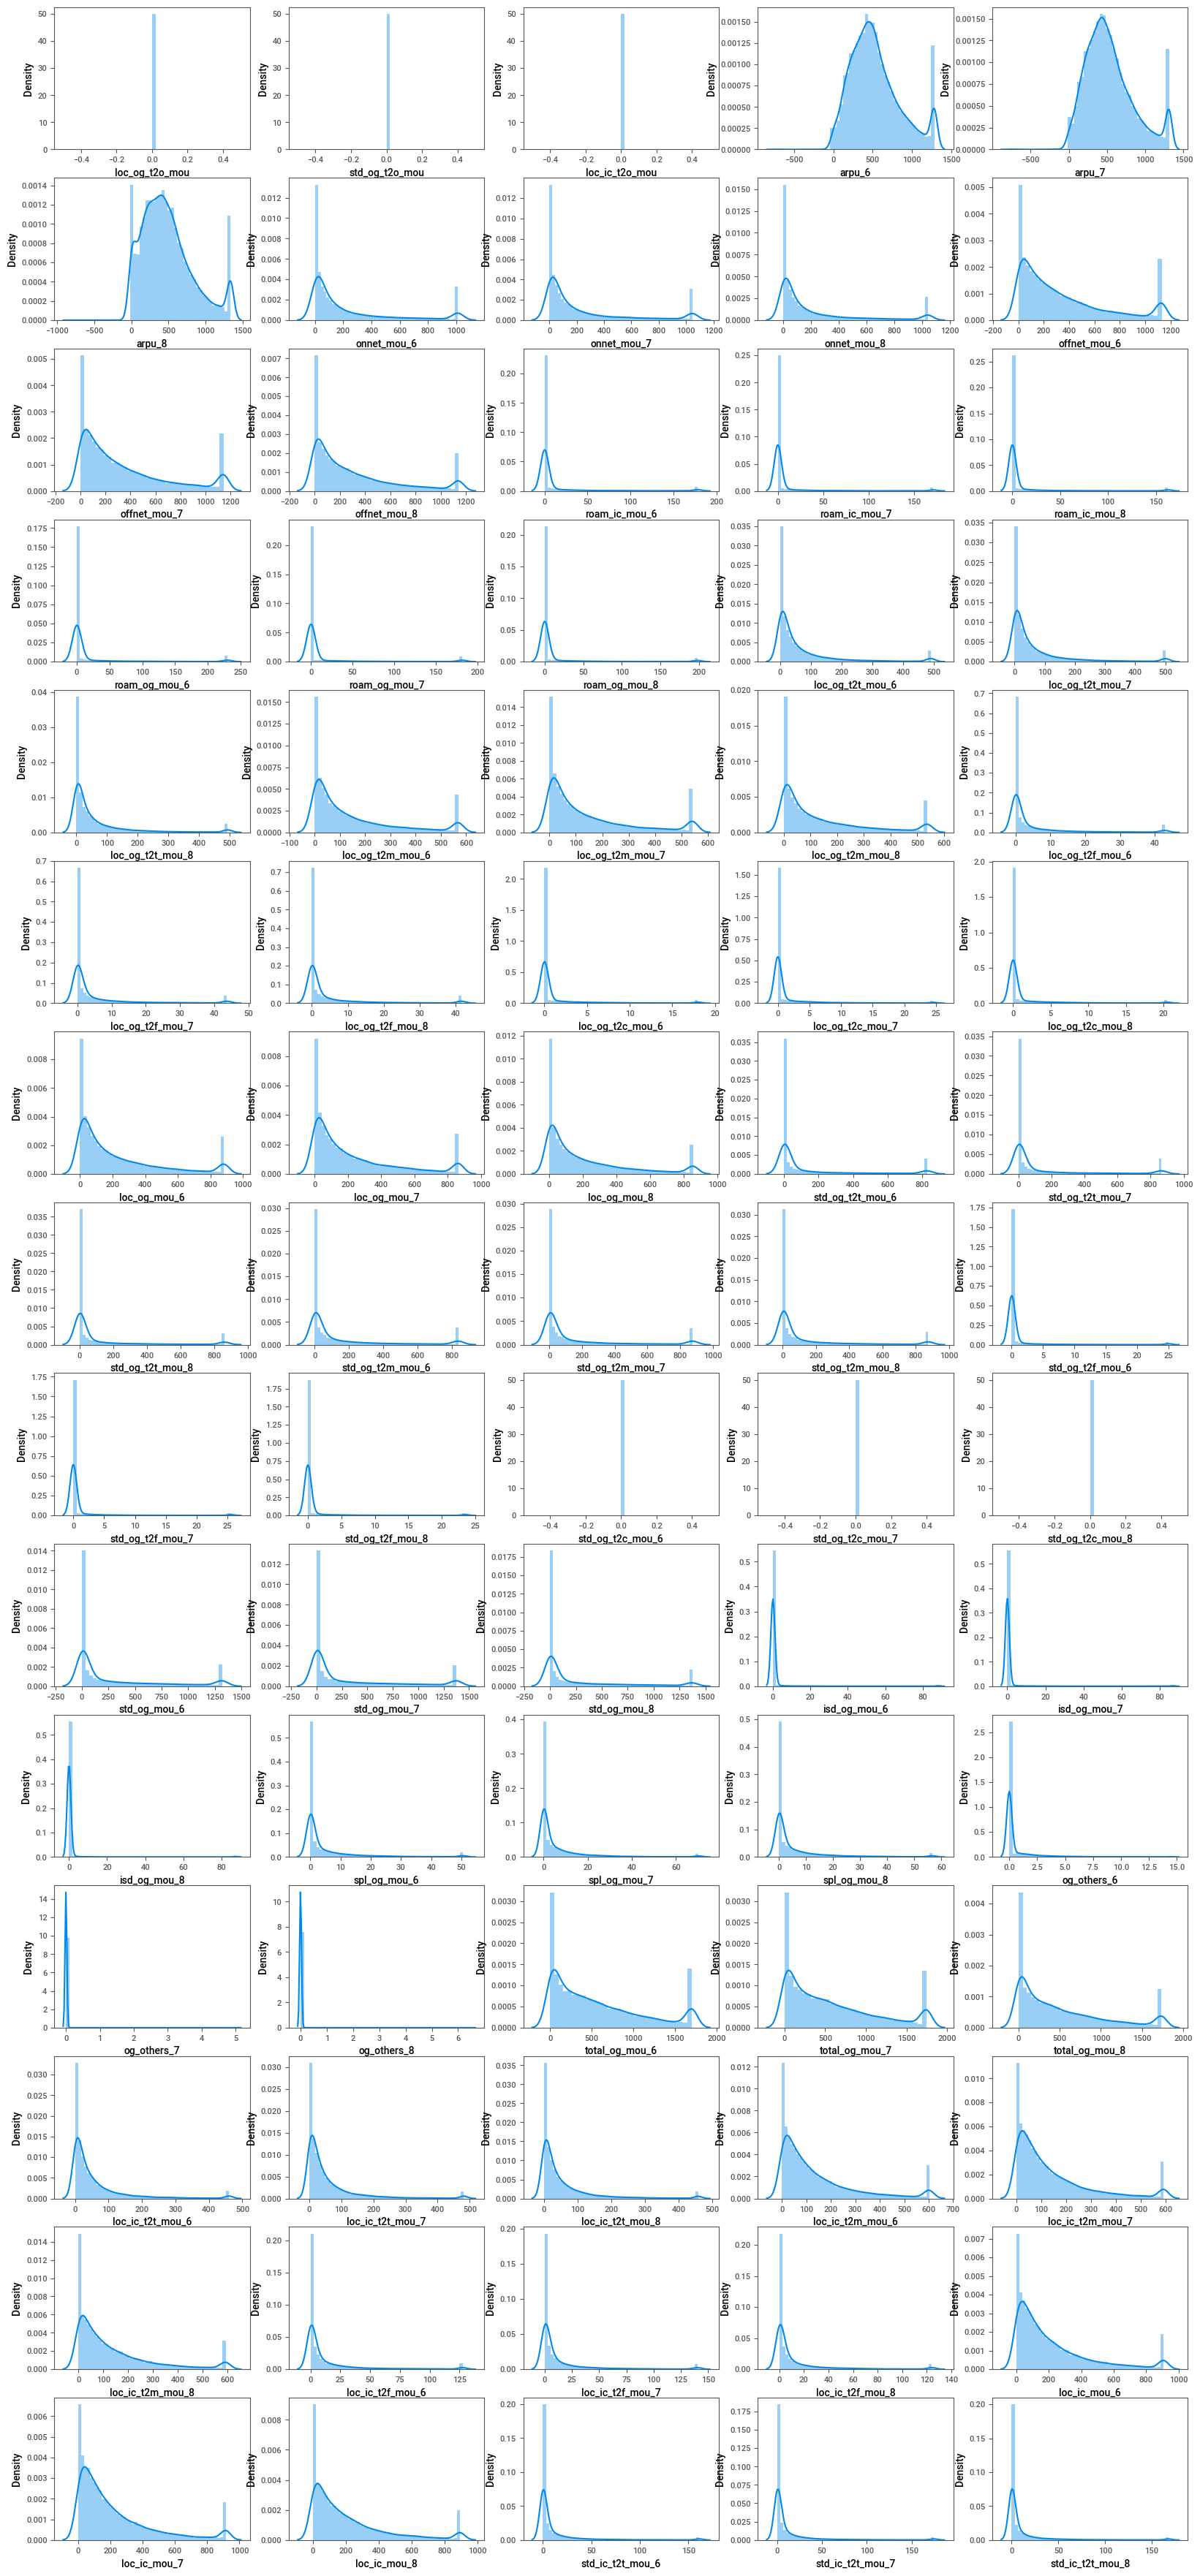

In [357]:
#List of all numeric variables

plt.figure(figsize=(20,45))

i = 1
for variables in numericColumns[sl]:
    plt.subplot(15,5,i)
    sns.distplot(churn_filtered[variables])
    i+=1
    
plt.show()

In [358]:
sl = slice(75, 149)
print(len(numericColumns[sl]))

74


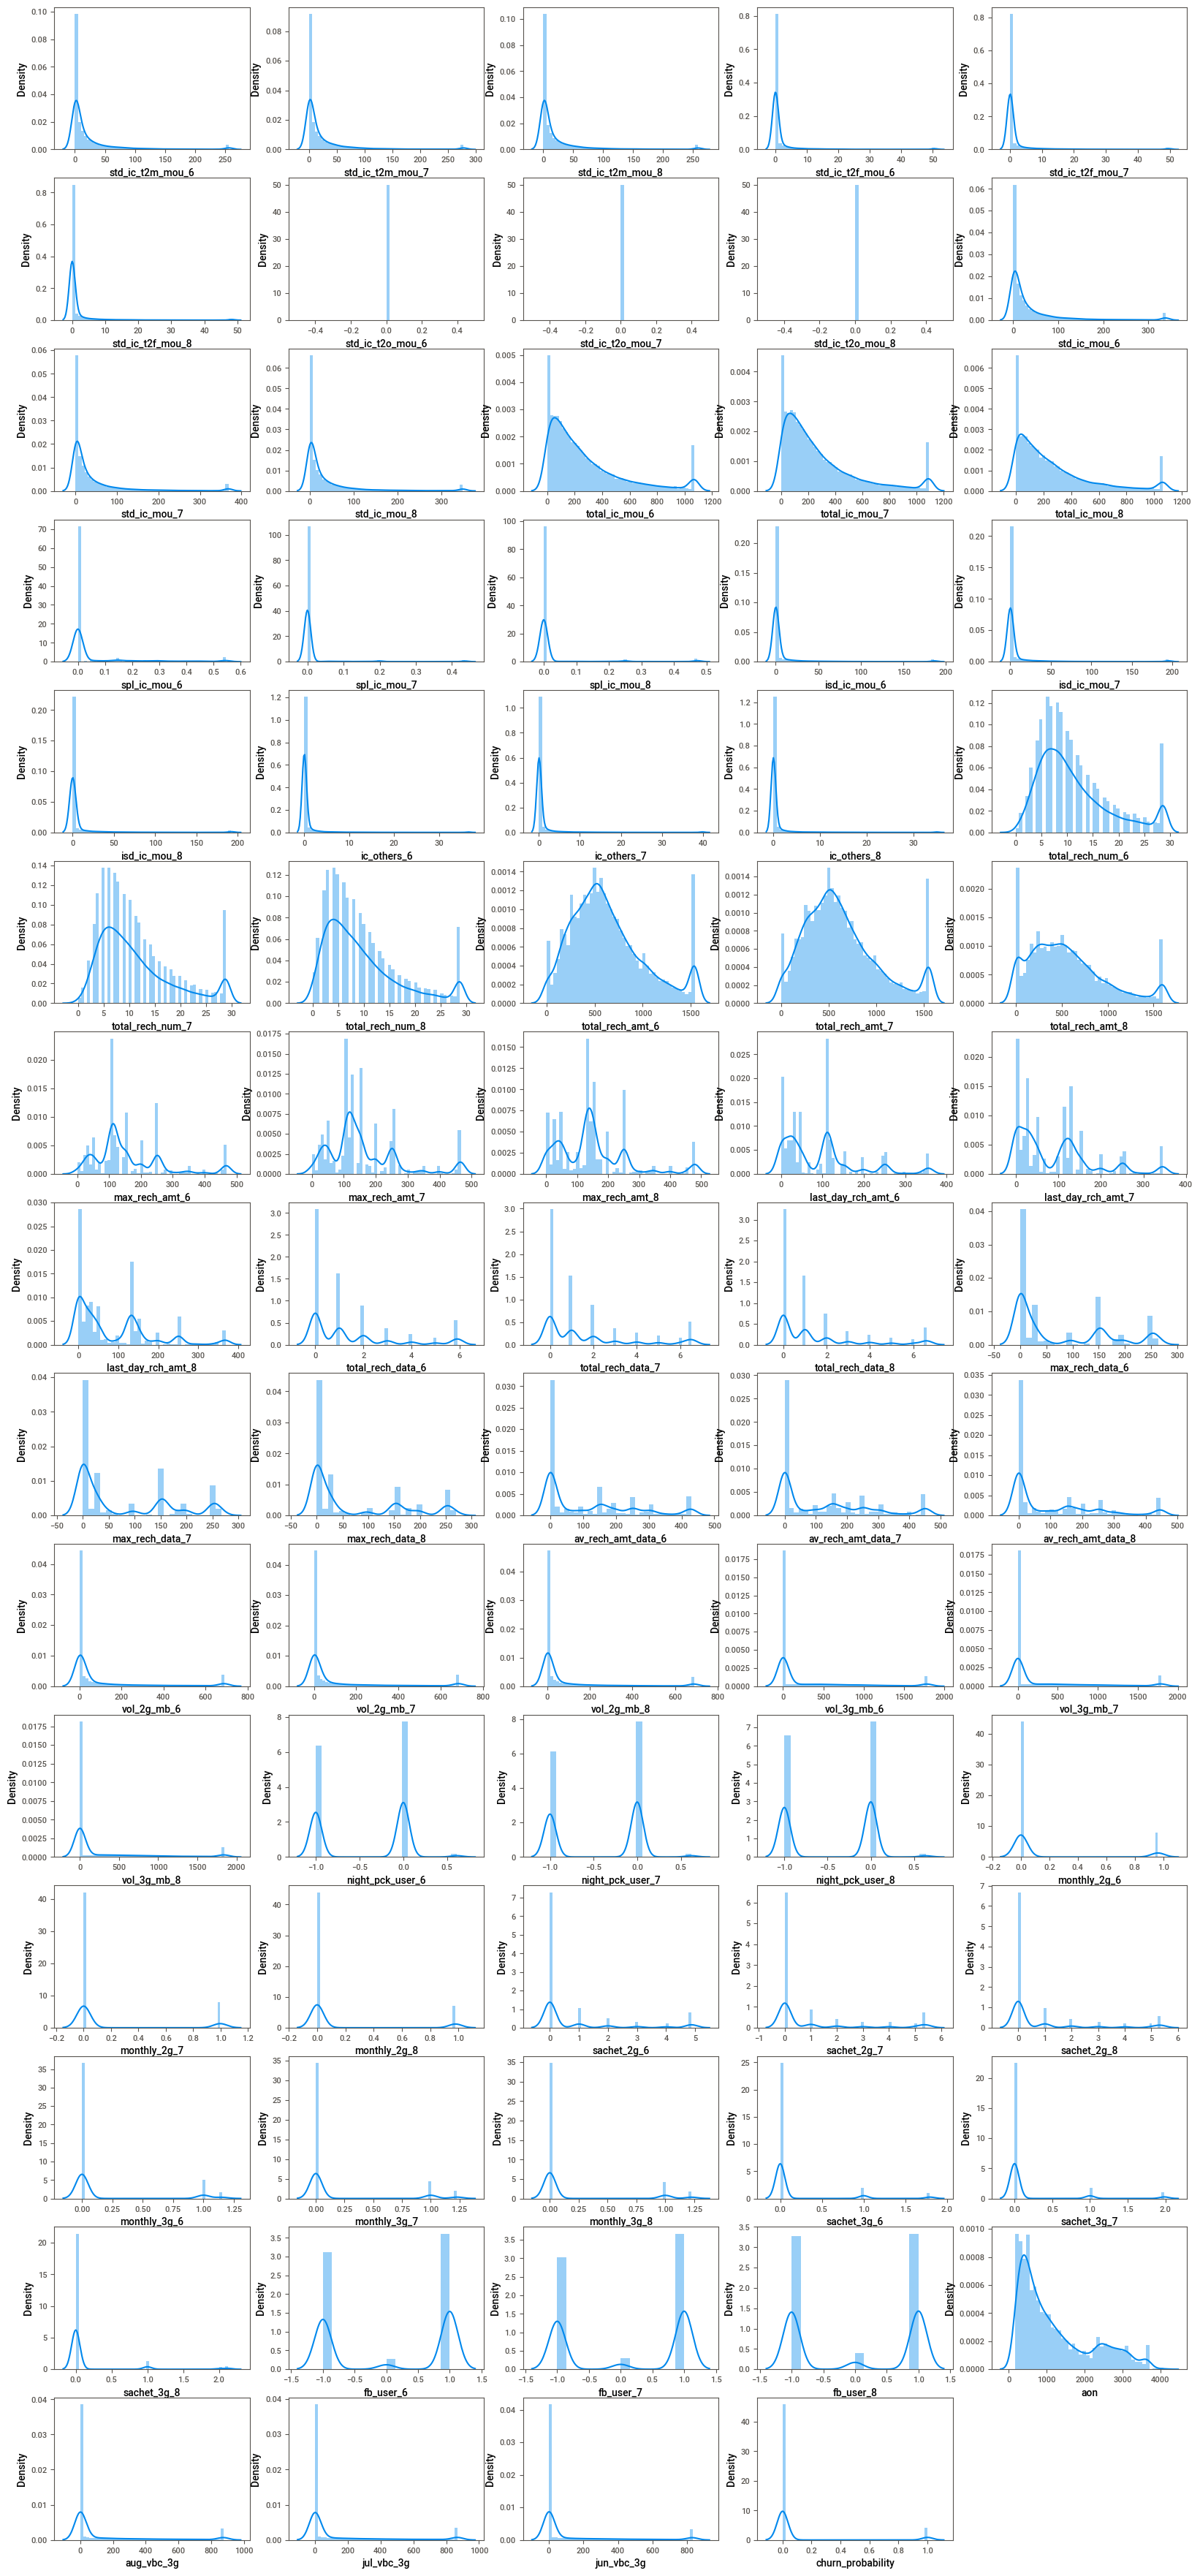

In [359]:
#numeric variables

plt.figure(figsize=(20,45))

i = 1
for variables in numericColumns[sl]:
    plt.subplot(15,5,i)
    sns.distplot(churn_filtered[variables])
    i+=1
    
plt.show()

#### Inference : Lot of variables are skewed towards left. Indicating that values around zero.

In [360]:
# create plotting functions
def data_type(variable):
    if variable.dtype == np.int64 or variable.dtype == np.float64:
        return 'numerical'
    elif variable.dtype == 'category':
        return 'categorical'

def univariate(variable, stats=True):

    if data_type(variable) == 'numerical':
        sns.distplot(variable)
        if stats == True:
            print(variable.describe())

    elif data_type(variable) == 'categorical':
        sns.countplot(variable)
        if stats == True:
            print(variable.value_counts())

    else:
        print("Invalid variable passed: either pass a numeric variable or a categorical vairable.")

def bivariate(var1, var2):
    if data_type(var1) == 'numerical' and data_type(var2) == 'numerical':
        sns.regplot(x=var1, y=var2)
    elif (data_type(var1) == 'categorical' and data_type(var2) == 'numerical') or (data_type(var1) == 'numerical' and data_type(var2) == 'categorical'):
        sns.boxplot(x=var1, y=var2)

## Bivariate EDA

<Axes: xlabel='churn_probability', ylabel='Count'>

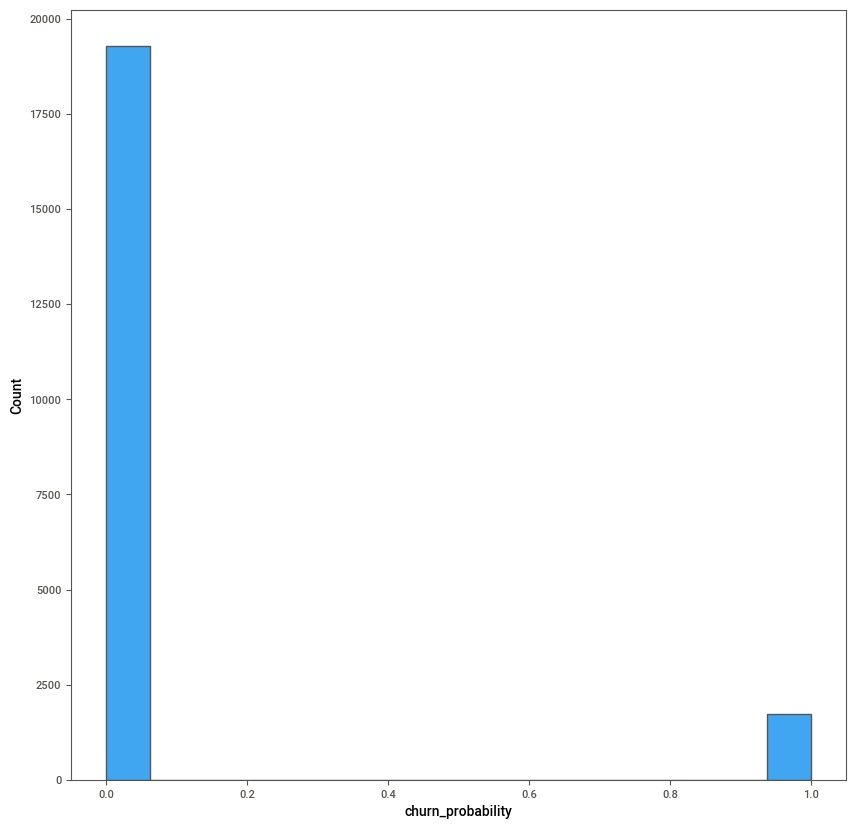

In [361]:
#Distribution for the churn probability
sns.histplot(churn_filtered['churn_probability'])

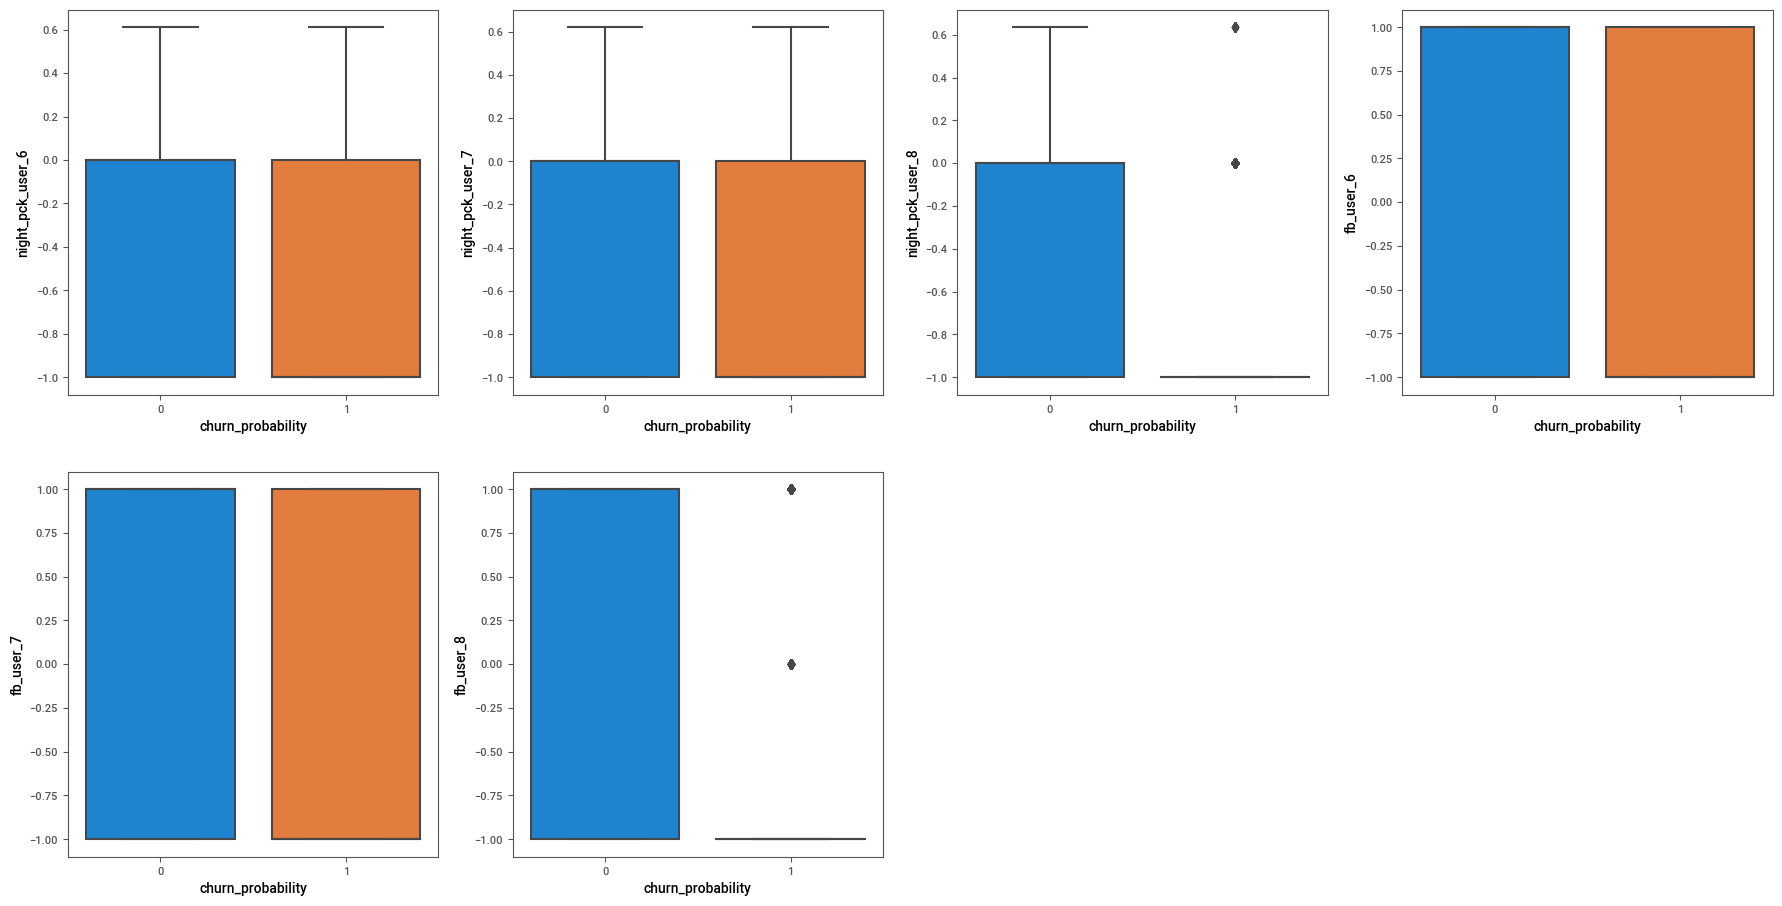

In [362]:
# All Categorical columns Bivariate analysis

plt.figure(figsize=(22,29))

i = 1
for variables in cat_cols:
    plt.subplot(5,4,i)
    sns.boxplot(y= variables , x= churn_filtered.churn_probability, data=churn_filtered )
    i+=1

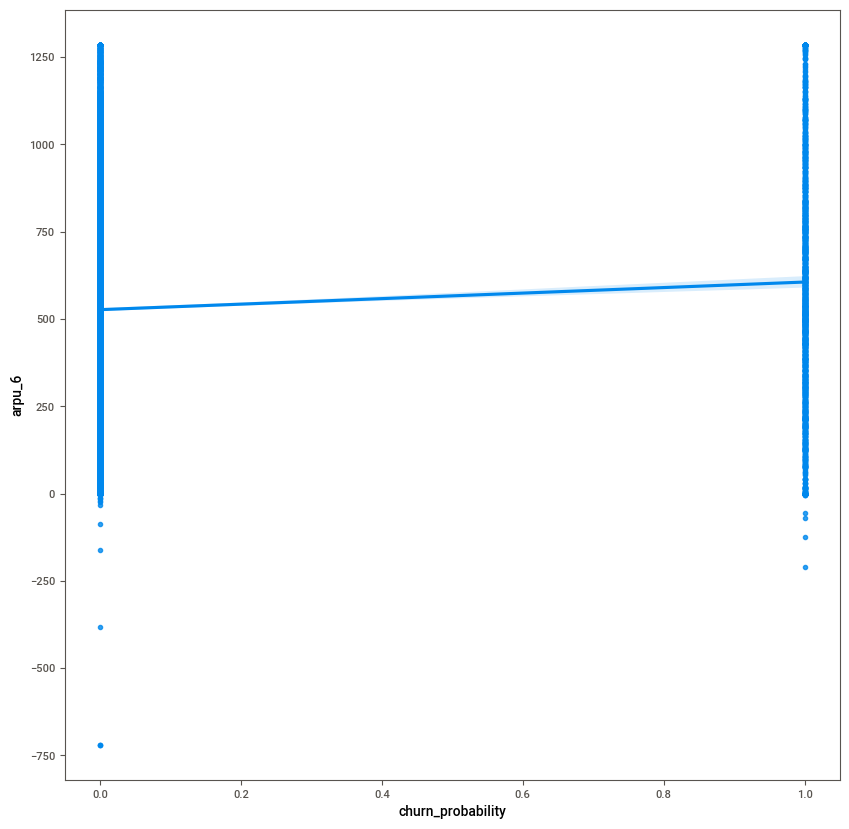

In [364]:
#Age on netwrok with churn
bivariate(churn_filtered.churn_probability, churn_filtered.arpu_6)

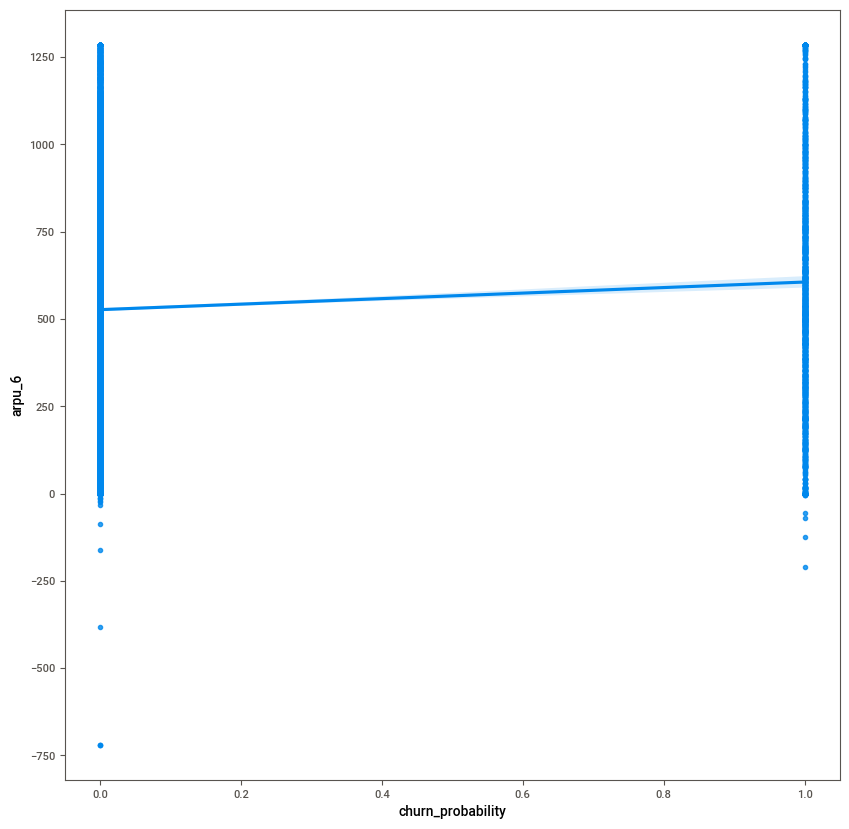

In [364]:
#Age on netwrok with churn
bivariate(churn_filtered.churn_probability, churn_filtered.arpu_6)

In [365]:
pd.crosstab(churn_filtered.churn_probability, churn_filtered.night_pck_user_8, normalize='columns')*100

night_pck_user_8,-1.000000,0.000000,0.635294
churn_probability,,,
0,85.80002,96.975235,97.046414
1,14.19998,3.024765,2.953586


In [366]:
pd.crosstab(churn_filtered.churn_probability, churn_filtered.sachet_3g_8)

sachet_3g_8,0.000000,1.000000,2.000000,2.125593
churn_probability,,,,
0,17450,1146,279,402
1,1684,33,3,14


## 4. Model building

### Feature engineering and selection

#### Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [367]:
churn_filtered.shape

(21011, 149)

In [368]:
churn_filtered

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0.0,0.0,0.0,240.708,128.191000,101.565000,21.28,4.83,6.13,56.99,...,1.000000,0.0,1.0,1.0,1.0,647.0,0.00,0.00000,0.000000,0
1,0.0,0.0,0.0,580.549,377.294000,338.286000,10.43,24.99,194.43,317.11,...,0.000000,0.0,1.0,-1.0,1.0,602.0,0.00,0.00000,0.000000,0
2,0.0,0.0,0.0,1130.948,905.506000,479.762000,859.53,372.71,0.89,293.46,...,0.000000,0.0,-1.0,-1.0,-1.0,455.0,0.00,0.00000,0.000000,0
3,0.0,0.0,0.0,371.974,352.069000,240.449000,93.18,38.29,29.86,531.19,...,0.000000,0.0,0.0,0.0,0.0,1219.0,0.00,0.00000,0.000000,0
4,0.0,0.0,0.0,390.489,350.985000,421.300000,8.58,11.48,12.68,133.16,...,1.000000,1.0,1.0,1.0,1.0,573.0,700.40,185.71000,173.720000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21006,0.0,0.0,0.0,1106.130,1311.286693,1334.631771,84.91,133.44,178.08,823.86,...,0.000000,0.0,1.0,-1.0,-1.0,283.0,6.48,102.80000,127.410000,0
21007,0.0,0.0,0.0,196.695,298.645000,192.440000,1.05,0.00,5.83,44.74,...,1.985085,1.0,1.0,1.0,1.0,251.0,107.77,112.70000,242.180000,0
21008,0.0,0.0,0.0,235.524,195.633000,129.598000,45.08,94.31,8.34,111.51,...,0.000000,0.0,1.0,1.0,-1.0,1507.0,0.00,16.53000,18.840000,0
21009,0.0,0.0,0.0,15.760,410.924000,329.136000,0.00,7.36,10.93,0.00,...,1.000000,0.0,-1.0,1.0,1.0,221.0,0.00,0.00000,0.000000,0


In [369]:
# change churn to numeric
churn_filtered['churn_probability'] = pd.to_numeric(churn_filtered['churn_probability'])

In [370]:
# divide data into train and test
X = churn_filtered.drop("churn_probability", axis = 1)
y = churn_filtered.churn_probability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [371]:
# print shapes of train and test sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14707, 148)
(14707,)
(6304, 148)
(6304,)


## PCA

In [372]:
# apply pca to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [373]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

In [374]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

In [375]:
pca.components_

array([[-1.64070288e-19,  2.49800181e-16, -5.55111512e-17, ...,
        -6.59980698e-02, -7.07128866e-02, -6.84486077e-02],
       [-3.39847528e-19,  1.11022302e-16,  4.44089210e-16, ...,
         1.14335312e-01,  1.09622127e-01,  1.05161551e-01],
       [-6.87658535e-19,  3.33066907e-16, -2.22044605e-16, ...,
         1.29471630e-01,  1.26996899e-01,  1.19299222e-01],
       ...,
       [ 0.00000000e+00, -2.45835437e-03, -2.63987959e-03, ...,
         1.86293038e-16,  8.13151629e-19, -6.03629560e-17],
       [-0.00000000e+00,  3.21129947e-02,  5.14766815e-02, ...,
         7.24247051e-17, -5.42101086e-17,  1.60461922e-17],
       [ 9.99977601e-01, -5.67163334e-03,  3.55378841e-03, ...,
         9.75781955e-19, -5.42101086e-19, -2.16840434e-19]])

In [376]:
pca.explained_variance_ratio_

array([1.45137243e-01, 1.14555422e-01, 6.15469519e-02, 4.96738806e-02,
       4.21284451e-02, 3.03910487e-02, 2.61377008e-02, 2.52568058e-02,
       2.41113042e-02, 2.20412444e-02, 2.14375904e-02, 1.86630310e-02,
       1.80793466e-02, 1.62971496e-02, 1.50578645e-02, 1.48112961e-02,
       1.40158233e-02, 1.32310423e-02, 1.30100942e-02, 1.18675413e-02,
       1.10592525e-02, 1.03588881e-02, 9.66850161e-03, 9.56797706e-03,
       9.00254379e-03, 8.76186739e-03, 8.64015403e-03, 8.30847480e-03,
       8.04619209e-03, 7.38540081e-03, 7.26325580e-03, 6.90358601e-03,
       6.49534023e-03, 6.35143921e-03, 6.20061273e-03, 6.11168876e-03,
       5.95100728e-03, 5.51885481e-03, 5.44477887e-03, 5.17956165e-03,
       5.07230841e-03, 4.88625038e-03, 4.72157263e-03, 4.60908182e-03,
       4.56886415e-03, 4.34182803e-03, 4.07211385e-03, 4.04347936e-03,
       3.94566979e-03, 3.81754495e-03, 3.68461301e-03, 3.55128424e-03,
       3.52187754e-03, 3.40259863e-03, 3.37593087e-03, 3.34826109e-03,
      

<BarContainer object of 148 artists>

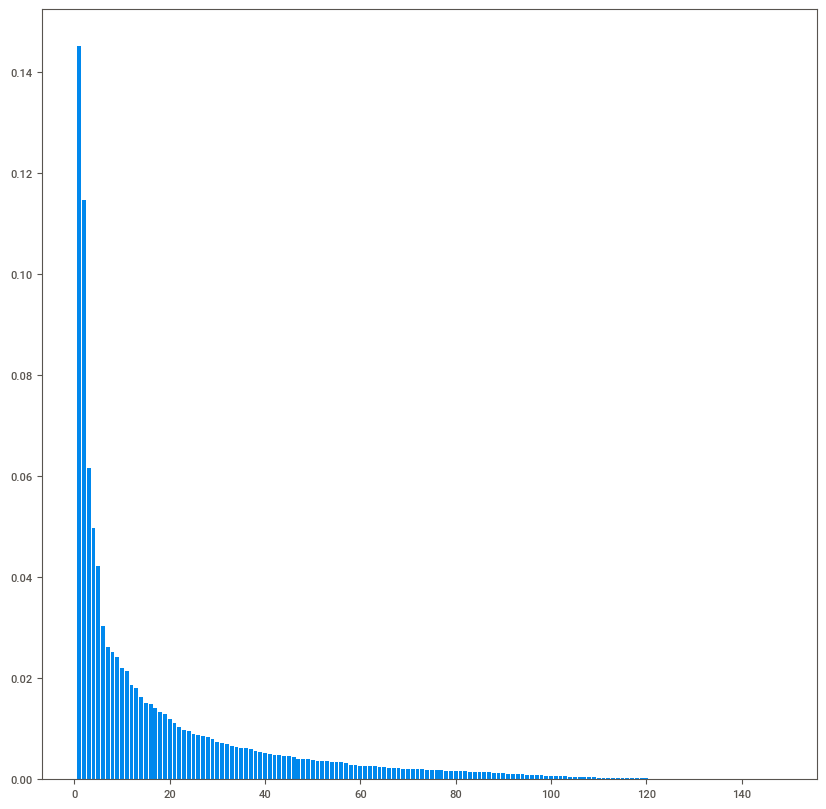

In [377]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

In [378]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

#### Making the scree plot

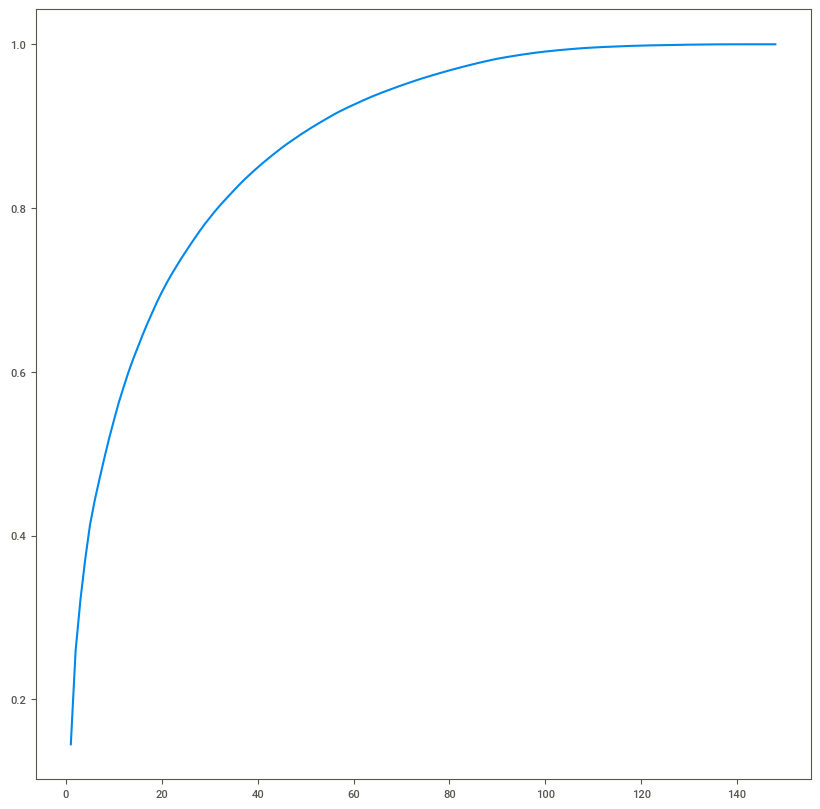

In [379]:
plt.plot(range(1,len(var_cumu)+1), var_cumu)

Inference from Scree plot is : About 60 components are able to explain 90% of feature variance so let's consider 60 components

## PCA and Logistic Regression

In [380]:
# create pipeline
PCA_VARS = 60
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(steps)

In [381]:
# fit model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=60)),
                ('logistic', LogisticRegression(class_weight='balanced'))])

In [382]:
# check score on train data
pipeline.score(X_train, y_train)

0.8226694771197389

### Evaluate on test data

In [383]:
# predict churn on test data
y_pred = pipeline.predict(X_test)

In [384]:
pipeline.score(X_test, y_test)

0.819479695431472

In [385]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[4731 1053]
 [  85  435]]


In [386]:
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

Sensitivity: 	0.84
Specificity: 	0.82


In [387]:
# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

AUC:    	 0.9


### Hyperparameter tuning - PCA and Logistic Regression

In [105]:
# class imbalance
y_train.value_counts()/y_train.shape

0    0.917454
1    0.082546
Name: churn_probability, dtype: float64

In [106]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight={0:0.1, 1: 0.9})

# create pipeline
steps = [("scaler", StandardScaler()),
         ("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)


In [107]:

# hyperparameter space
params = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

In [108]:
# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [109]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [60, 80]},
             scoring='roc_auc', verbose=1)

In [110]:
# cross validation results
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.426091,0.007905,0.000000,0.000000,0.1,l1,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
1,0.592011,0.038748,0.000000,0.000000,0.1,l1,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2,0.604211,0.022115,0.018990,0.006115,0.1,l2,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.897499,0.893076,0.890155,0.891547,0.882100,0.890875,0.005034,11
3,0.705600,0.046420,0.013068,0.002728,0.1,l2,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.902281,0.894218,0.894200,0.893001,0.884851,0.893710,0.005530,1
4,0.486718,0.037713,0.000000,0.000000,0.5,l1,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
5,0.591229,0.025396,0.000000,0.000000,0.5,l1,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
6,0.554637,0.051522,0.011491,0.003757,0.5,l2,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.898216,0.892977,0.890007,0.889346,0.881357,0.890380,0.005491,14
7,0.712575,0.033617,0.013519,0.006378,0.5,l2,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.902212,0.894591,0.894297,0.891406,0.885393,0.893580,0.005437,2
8,0.436563,0.040778,0.000000,0.000000,1,l1,60,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
9,0.558705,0.037577,0.000000,0.000000,1,l1,80,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17


In [111]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8937102034262325
Best hyperparameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'pca__n_components': 80}


In [112]:
# predict churn on test data
y_pred = model.predict(X_test)

In [113]:
# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[4925  859]
 [  94  426]]


In [114]:
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

Sensitivity: 	0.82
Specificity: 	0.85
AUC:    	 0.9


### Random Forest

In [115]:
# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [116]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/mahalakshmi/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahalakshmi/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahalakshmi/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this p

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.1, 1: 0.9},
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 0.4]},
             scoring='roc_auc', verbose=1)

In [117]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.9256240491775716
Best hyperparameters:  {'criterion': 'entropy', 'max_features': 0.4}


In [118]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[5708   76]
 [ 266  254]]
Sensitivity: 	0.49
Specificity: 	0.99
AUC:    	 0.93


## ii) Choosing best features

In [119]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)

12


In [120]:
# fit model
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.4s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=12,
                       oob_score=True, random_state=4, verbose=1)

In [121]:
# OOB score
rf_model.oob_score_

0.9407085061535323

In [122]:
# predict churn on test data
y_pred = rf_model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[5729   55]
 [ 292  228]]
Sensitivity: 	0.44
Specificity: 	0.99
ROC:    	 0.93


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


### Feature Importance

In [124]:
# predictors
features = churn_filtered.drop('churn_probability', axis=1).columns

# feature_importance
importance = rf_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())
feature_importance

Sum of importance= 100.0


,variables,importance_percentage
0,total_ic_mou_8,7.166223
1,loc_ic_mou_8,5.620362
2,loc_ic_t2t_mou_8,4.750378
3,loc_ic_t2m_mou_8,4.131418
4,loc_og_mou_8,3.823842
...,...,...
143,std_ic_t2o_mou_6,0.000000
144,std_ic_t2o_mou_7,0.000000
145,loc_ic_t2o_mou,0.000000
146,std_ic_t2o_mou_8,0.000000


### Extracting top 30 features

In [125]:
# extract top 'n' features
top_n = 30
top_features = feature_importance.variables[0:top_n]

<Axes: >

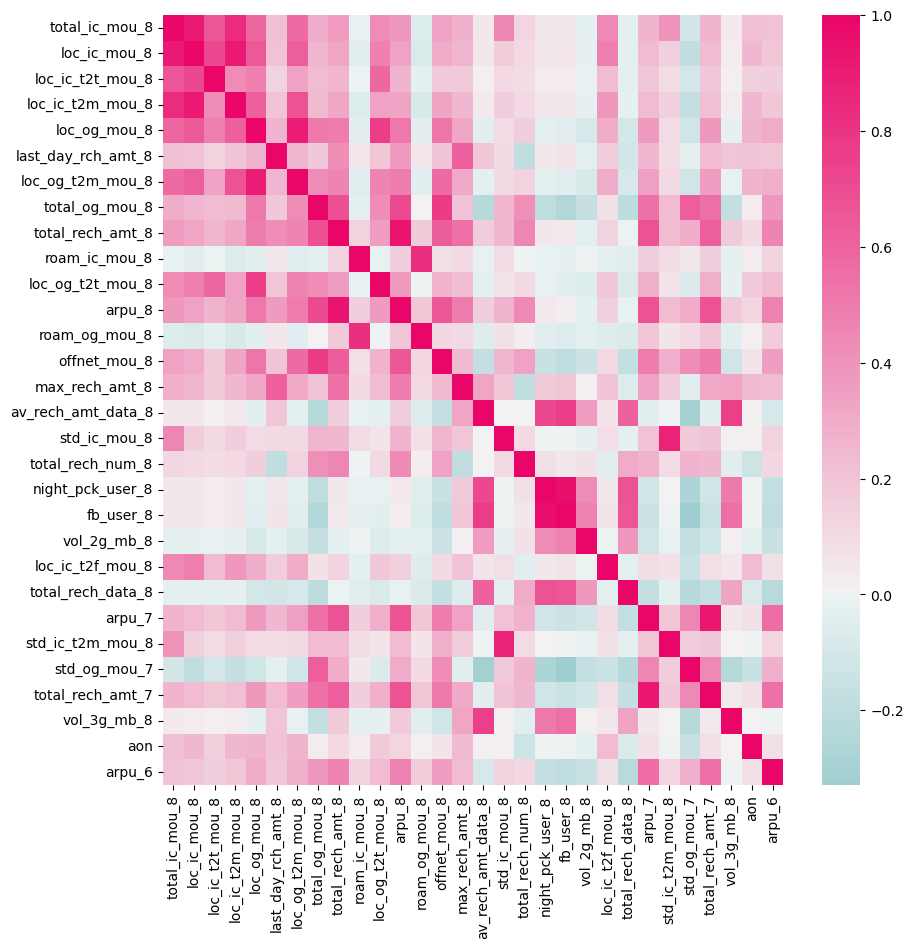

In [126]:
# plot feature correlation
import seaborn as sns
plt.rcParams["figure.figsize"] =(10,10)
mycmap = sns.diverging_palette(199, 359, s=99, center="light", as_cmap=True)
sns.heatmap(data=X_train[top_features].corr(), center=0.0, cmap=mycmap)

In [127]:
# top_features = ['total_ic_mou_8',  'total_og_mou_8', 'arpu_8', 'roam_ic_mou_8', 'roam_og_mou_8',
#                 'std_ic_mou_8', 'av_rech_amt_data_8', 'std_og_mou_8']
top_features = ['total_ic_mou_8',  'total_og_mou_8', 'arpu_8', 'roam_ic_mou_8', 'roam_og_mou_8',
                'std_ic_mou_8', 'av_rech_amt_data_8', 'std_og_mou_8']

X_train = X_train[top_features]
X_test = X_test[top_features]

In [128]:
# logistic regression
steps = [('scaler', StandardScaler()),
         ("logistic", LogisticRegression(class_weight={0:0.1, 1:0.9}))
        ]

# compile pipeline
logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [129]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [130]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.86835334836254
Best hyperparameters:  {'logistic__C': 4, 'logistic__penalty': 'l2'}


In [131]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[4611 1173]
 [ 101  419]]
Sensitivity: 	0.81
Specificity: 	0.8
ROC:    	 0.88


### Extract the intercept and the coefficients from the logistic model

In [132]:
logistic_model = model.best_estimator_.named_steps['logistic']

In [133]:
# intercept
intercept_df = pd.DataFrame(logistic_model.intercept_.reshape((1,1)), columns = ['intercept'])

In [134]:
# coefficients
coefficients = logistic_model.coef_.reshape((8, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

logistic_features = list(X_train.columns)
coefficients_df = pd.DataFrame(logistic_model.coef_, columns=logistic_features)

In [135]:
# concatenate dataframes
coefficients = pd.concat([intercept_df, coefficients_df], axis=1)
coefficients

,intercept,total_ic_mou_8,total_og_mou_8,arpu_8,roam_ic_mou_8,roam_og_mou_8,std_ic_mou_8,av_rech_amt_data_8,std_og_mou_8
0,-1.461447,-1.318385,-1.037019,-0.149934,-0.028027,0.270064,0.093124,-1.009873,0.556848


# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [550]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [551]:
unseen.head()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,746.239,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,24.400,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,413.329,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [559]:
submission_data = unseen.set_index('id')[X_train.columns]
submission_data.shape

(30000, 148)

In [564]:
submission_data.isna().sum()

loc_og_t2o_mou      316
std_og_t2o_mou      316
loc_ic_t2o_mou      316
arpu_6                0
arpu_7                0
                  ...  
fb_user_8         22078
aon                   0
aug_vbc_3g            0
jul_vbc_3g            0
jun_vbc_3g            0
Length: 148, dtype: int64

In [ ]:
#handle missing values in submission_data

In [566]:
imp = SimpleImputer(strategy='constant', fill_value=0)
submission_data_filtered = imp.fit_transform(submission_data)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [567]:
unseen['churn_probability'] = pipeline.predict(submission_data_filtered)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [568]:
output.to_csv('submission_pca_lr_dec7.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.